In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from scipy import stats


def get_val(dnad,rna,n,updown,rnap=.05):
    pl_all=[]
    ## all genes
    cor_sub=rna.copy()
    cor_sub['q']='Among all transcripts'
    if updown=='up':
        cor_sub['pp']=(cor_sub['rna_cor']>0)&(cor_sub['rna_p']<rnap) #up
    else:
        cor_sub['pp']=(cor_sub['rna_cor']<0)&(cor_sub['rna_p']<rnap) #down            
    pl_all.append(cor_sub[['cohort','pp','q','rna_cor']])

    ## aging genes
    if updown=='up':
        cor_sub=rna[rna['proposed']=='up'].copy()
        cor_sub['q']="Among Peters et al's\n aging transcripts"
        cor_sub['pp']=(cor_sub['rna_cor']>0)&(cor_sub['rna_p']<rnap) #up
    else:
        cor_sub=rna[rna['proposed']=='down'].copy()
        cor_sub['q']="Among Peters et al's\n aging transcripts"
        cor_sub['pp']=(cor_sub['rna_cor']<0)&(cor_sub['rna_p']<rnap) #down
    pl_all.append(cor_sub[['cohort','pp','q','rna_cor']])

    ## .01
    for i in [1,2]:
        q=10**(-i)
        dd=dnad.copy() ### 2000 fromTSS
        if updown=='up':
            dd['p']=(dd['p']<q)&(dd['cor']<0)              #DNAm loss
        else:
            dd['p']=(dd['p']<q)&(dd['cor']>0)              #DNAm gain
        dd['p+']=dd['p'].shift(1); dd['cg+']=dd['cg'].shift(1)
        dd['p-']=dd['p'].shift(-1); dd['cg-']=dd['cg'].shift(-1)
        dd['p3']=dd['p']&dd['p+']&dd['p-']
        ddp=dd[dd['p3']==True]
        cor_sub=rna[rna.index.isin(ddp['gene'])].copy()
        cor_sub['q']='Among aging trans. &\n aging CpGs (p='+str(q)+')'
        if updown=='up':
            cor_sub=cor_sub[cor_sub['proposed']=='up']              #up
            cor_sub['pp']=(cor_sub['rna_cor']>0)&(cor_sub['rna_p']<rnap)  #up
        else:
            cor_sub=cor_sub[cor_sub['proposed']=='down']           #down
            cor_sub['pp']=(cor_sub['rna_cor']<0)&(cor_sub['rna_p']<rnap) #down
        pl_all.append(cor_sub[['cohort','pp','q','rna_cor']])   
    pl_all=pd.concat(pl_all) 
    return pl_all,ddp

def plot_val(pl_all,order):
    ax=sns.barplot(data=pl_all,x='cohort',y='pp',hue='q',order=order)
    ax.set(ylim=[0,1],xlabel='',ylabel='')
    ax.set_yticks(ax.get_yticks());ax.set_xticks(ax.get_xticks());
    ax.set_yticklabels([])
    legend = ax.legend()
    if updown=='up':
        plt.title('Up-regulated',size=14);    
    else:
        plt.title('Down-regulated',size=14);   
    return ax

dis_n=2000 
data='../data/'

In [2]:
man=pd.read_csv(data+'clean/man_e2.csv',index_col=0,usecols=['Name','ch','pos','dis','gene','tss'])
man=man.drop_duplicates()
dna=pd.read_csv(data+'results/dna_corr/mgb.csv',index_col=0)
dna=man.join(dna,how='inner')
dna=dna.sort_values(['ch','pos'])
dnad=dna[dna['dis'].abs()<=dis_n].copy() ### 2000 fromTSS
dnad['cg']=dnad.index
dna.shape

(825095, 8)

In [6]:
dna[dna['gene']=='GZMK'].head(1)

,ch,pos,dis,gene,tss,cor,p,cohort
cg14597388,5,55023545,-711,GZMK,5055024256,-0.178342,0.000118,mgb


In [3]:
rna_all=pd.read_csv(data+'results/rna_cor.csv',index_col=0).rename(columns={'cor':'rna_cor','p':'rna_p'})
rna_all.index=rna_all['gen']
rna_all.shape

(113280, 6)

In [4]:
# Down Regulated and Gain of DNAm ---> significant
updown='down'
pl_all_out=[]
cohorts=rna_all['cohort'].unique()
for coh in cohorts:
    rna=rna_all[rna_all['cohort']==coh]
    val,ddp=get_val(dnad,rna,dis_n,updown)
    pl_all_out.append(val)
pl_all=pd.concat(pl_all_out).dropna()
g=pl_all[(pl_all['q']=='Among aging trans. &\n aging CpGs (p=0.01)')&(pl_all['cohort']=='MESA1')]

In [6]:
g[[]].to_csv(data+'results/aging_genes.csv')
g.shape

(106, 4)

In [7]:
pl_all[['cohort','q','pp']].to_csv(data+'figs/3g.csv')
pl_all.shape

(111167, 4)

In [8]:
pl_all['gene']=pl_all.index
mult_down=pl_all[(pl_all['q']=='Among aging trans. &\n aging CpGs (p=0.01)')&(pl_all['pp'])]
mult_down.to_csv(data+'results/validated_genes.csv')
topcg=ddp[ddp['gene'].isin(mult_down.index)&(ddp['p3'])]
len(topcg['gene'].unique())

106

In [9]:
topcg.to_csv(data+'results/panel_cpgs.csv')
cgs=dna[(dna['gene'].isin(topcg['gene']))&(dna['cor']>0)&(dna['p']<.01)&(dna['dis'].abs()<=2000)].sort_values(['ch','pos'])
cgs.to_csv(data+'results/aging_cgs.csv')
cgs.shape

(721, 8)

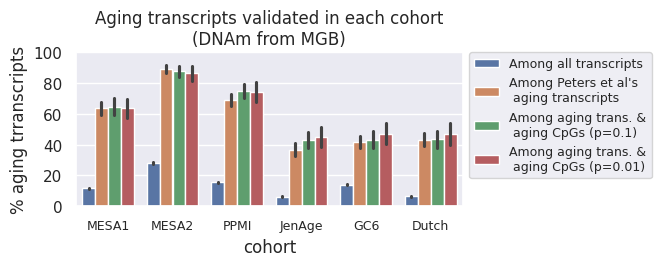

In [19]:
# Up Regulated and Loss of DNAm ---> NOT significant
updown='up'
pl_all_out=[]
cohorts=rna_all['cohort'].unique()
for coh in cohorts:
    rna=rna_all[rna_all['cohort']==coh]
    val,ddp=get_val(dnad,rna,dis_n,updown)
    pl_all_out.append(val)
pl_all=pd.concat(pl_all_out).dropna()
sns.set(rc={'figure.figsize':(5,2)})    
ax=plot_val(pl_all.reset_index(),order=['MESA1','MESA2','PPMI','JenAge','GC6','Dutch'])
ax.set_xticklabels(ax.get_xticklabels(), size = 9);
ax.set(ylim=[0,1],xlabel='cohort',ylabel='% aging trranscripts',
       title='Aging transcripts validated in each cohort\n(DNAm from MGB)');
ax.set_yticklabels(['0','20','40','60','80','100'])
plt.legend(bbox_to_anchor=(1, 1.04),fontsize=9);

In [21]:
%%time
fig3g=pl_all
fig3g.to_csv(data+'figs/3g.csv')
fig3g.shape

CPU times: user 555 ms, sys: 6.97 ms, total: 562 ms
Wall time: 617 ms


(111321, 4)

In [ ]:
# up-regulated NOT significant
# down-regulated significant
m=100; n=2000
for rna_dir in ['up-regulated','down-regulated']:
    pls=[]
    for cohort in ['MESA1','MESA2','PPMI']:
        rna=rna_all[rna_all['cohort']==cohort]
        mul=dna.drop(['cohort'],axis=1).merge(rna[['rna_cor','rna_p','cohort']],left_on=['gene'],right_index=True,how='inner')
        muld=mul[mul['dis'].abs()<n]    
        muld=muld.sort_values('rna_cor').copy()
        muld['rna_c']='all transcripts'
        if rna_dir=='down-regulated':
            muld.loc[muld.index[:m],'rna_c']=rna_dir
        else:
            muld.loc[muld.index[-m:],'rna_c']=rna_dir
        pl=muld[['rna_c','cor','cohort']]
        pls.append(pl)
    pls=pd.concat(pls)
    pls.loc[pls['rna_c']==rna_dir,'dot_plot']=pls.loc[pls['rna_c']==rna_dir,'cor']

In [22]:
%%time
fig3f=pls[['rna_c','cor','cohort','dot_plot']]
fig3f.to_csv(data+'figs/3f.csv')
fig3f.shape

CPU times: user 4.45 s, sys: 74.2 ms, total: 4.52 s
Wall time: 4.63 s


(870336, 4)